**Студент: Разуев Г.А.**
<br>
**Группа:  КЭ - 403**

# Задание

1. Разработайте программу, которая выполняет кластеризацию заданного набора данных с помощью алгоритмов k‑Means и k-Medoids. Параметрами программы являются набор данных и число кластеров. Программа должна выдавать координаты точек и назначенные им кластера, а также значение ошибки кластеризации.

2. Проведите эксперименты на наборе данных customers (сведения о клиентах банка: скачать zip-архив с данными в формате CSV и описанием). 

3. Выполните визуализацию полученных результатов в следующем виде:
    * точечный график, на котором цвет точки отражает принадлежность кластеру;
    * зависимость ошибки кластеризации от параметра k.

4. Доработайте программу, добавив в список ее параметров долю зашумленных объектов набора. Дополнительно к ранее реализованным функциям программа должна вносить шум в набор данных: случайным образом изменить заданную долю объектов набора (изменение может заключаться в добавлении/вычитании случайного числа к/из одной/нескольких координат объекта).

5. Проведите эксперименты на ранее выбранных наборах данных, варьируя долю зашумленных объектов (1%, 3%, 5%, 10%) и используя различные значения параметра  (из интервала 3..9).

6. Выполните визуализацию полученных результатов указанным выше способом.


### Данные 
Данные о клиентах банка.


Атрибуты:
* Row - порядковый номер строки
* CustomerId - уникальный идентификатор клиента
* Age - возраст (полных лет)
* Education - образование (целочисленный код)
* YearsEmployed - трудовой стаж (полных лет)
* Income - доход (K$ d год)
* CardDebt - задолженность по карте (вещественное)
* OtherDebt - прочие задолженности (вещественное)
* Defaulted - признавался банкротом, да/нет (вещественное 1.0/0.0)
* DebtIncomeRatio - отношение долга к доходам (веществыенное)

# 1. Реализация алгоритма

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from typing import List, Optional, Tuple, Dict
import os
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [61]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [83]:

class ClusteringEstimator:
    def __init__(self, n_clusters: int, algorithm: str = 'k-means'):
        if algorithm.lower() not in ['k-means', 'k-medoids']:
            raise ValueError("Algorithm should be either 'k-means' or 'k-medoids'")
        self.data = None
        self.n_clusters = n_clusters
        self.algorithm = algorithm
        self.estimator = None
        self.labels = None
        self.centroids = None
        self.error = None

    def add_noise(self, X: pd.DataFrame, noise_fraction: float) -> pd.DataFrame:
        """
        Вносит шум в данные, изменяя заданную долю объектов.
        
        :param X: pd.DataFrame, исходный набор данных
        :param noise_fraction: float, доля зашумленных объектов (от 0 до 1)
        :return: pd.DataFrame, зашумленный набор данных
        """
        if not (0 <= noise_fraction <= 1):
            raise ValueError("noise_fraction should be between 0 and 1")

        X = X.copy()
        n_samples = X.shape[0]
        n_noisy_samples = int(noise_fraction * n_samples)

        # Выбираем случайные индексы для зашумленных точек
        noisy_indices = np.random.choice(n_samples, n_noisy_samples, replace=False)

        # Добавляем шум к случайно выбранным точкам
        for idx in noisy_indices:
            # Добавляем или вычитаем случайное число от 0 до 1 из случайных координат
            noise = np.random.uniform(-1, 1, size=X.shape[1])  # Шум для каждой координаты
            X.iloc[idx] += noise

        return X

    def fit(self, X: pd.DataFrame, noise_fraction:float = 0) -> None:
        X = self.add_noise(X, noise_fraction)
        self.data = X

        if self.algorithm.lower() == 'k-means':
            kmeans = KMeans(n_clusters=self.n_clusters)
            self.estimator = kmeans
            self.labels = kmeans.fit_predict(X)
            self.centroids = kmeans.cluster_centers_

        elif self.algorithm.lower() == 'k-medoids':
            kmedoids = KMedoids(n_clusters=self.n_clusters)
            self.estimator = kmedoids
            self.labels = kmedoids.fit_predict(X)
            self.centroids = kmedoids.cluster_centers_

    @property
    def inertia(self) -> float:
        return self.estimator.inertia_
    
    @property
    def silhouette(self) -> float:
        if self.algorithm.lower() == 'k-means':
            return silhouette_score(self.data, self.labels)
        else:
            return float('nan')
        
    @property
    def data_with_labels(self) -> pd.DataFrame:
        return pd.DataFrame(self.data, columns=self.data.columns).assign(label=self.labels)
    
    @staticmethod
    def choose_optimal_n_clusters(n_clusters_range: List[int], X, sample_weight=None, 
                                  algorithm: str = 'k-means',
                                   init_params: Optional[Dict] = None, 
                                   method: str = 'elbow'):
        
        if algorithm.lower() not in ['k-means', 'k-medoids']:
            raise ValueError("Algorithm should be either 'k-means' or 'k-medoids'")        
        
        n_clusters_list = list(range(n_clusters_range[0], n_clusters_range[1] + 1))

        if method == 'elbow':
            inertia = []
            for n_clusters in n_clusters_list:
                if algorithm == 'k-means':
                    kmeans = KMeans(n_clusters=n_clusters, random_state=42, )
                    kmeans.fit(X=X, sample_weight=sample_weight)
                    inertia.append(kmeans.inertia_)
                else:
                    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42, )
                    kmedoids.fit(X=X)
                    inertia.append(kmedoids.inertia_)
                    

            # Визуализация удачи метода локтя
            with sns.axes_style("darkgrid"):
                fig, axes = plt.subplots(figsize=(8, 5))
                sns.lineplot(x=n_clusters_list, y=inertia, marker='o', ax=axes)
                axes.set_title('Метод локтя')
                axes.set_xlabel('Количество кластеров')
                axes.set_ylabel('Сумма квадратов расстояний')
                axes.set_xticks(n_clusters_list)

        elif method == 'silhouette':
            if algorithm == 'k-medoids':
                raise ValueError("Silhouette method is not available for k-medoids algorithm")
            scores = []
            for n_clusters in n_clusters_list:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, **(init_params if init_params else {}))
                kmeans.fit(X=X, sample_weight=sample_weight)
                labels = kmeans.predict(X)
                score = silhouette_score(X, labels)
                scores.append(score)

            # Визуализация метода силуэта
            with sns.axes_style("darkgrid"):
                fig, axes = plt.subplots(figsize=(8, 5))
                bar_plot = sns.barplot(x=n_clusters_list, y=scores, ax=axes)
                axes.set_title('Метод силуэта')
                axes.set_xlabel('Количество кластеров')
                axes.set_ylabel('Коэффициент силуэта')
                # axes.set_xticks(n_clusters_list)
                # axes.set_xticklabels(n_clusters_list)

            # Добавление подписей к столбцам
            for p in bar_plot.patches:
                bar_plot.annotate(f'{p.get_height():.2f}', 
                                (p.get_x() + p.get_width() / 2., p.get_height()), 
                                ha='center', va='bottom', fontsize=10)
        else:
            raise ValueError("Method should be either 'elbow' or 'silhouette'")
        
    def plot_clusters_with_tsne(self) -> None:
        """
        Рисует точечный график с использованием t-SNE, где цвет точки отражает принадлежность кластеру.

        :param data: np.ndarray, исходный массив данных (m x n)
        :param labels: np.ndarray, массив меток кластеров для каждой точки
        """
        # Применяем t-SNE для снижения размерности до 2
        tsne = TSNE(n_components=2, random_state=42)
        data_tsne = tsne.fit_transform(self.data)

        # Определяем уникальные метки (кластеры)
        unique_labels = np.unique(self.labels)

        # Задаем цветовую палитру
        colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

        # Создаем график
        plt.figure(figsize=(10, 6))

        for i, label in enumerate(unique_labels):
            # Выбираем точки, принадлежащие текущему кластеру
            cluster_points = data_tsne[self.labels == label]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=colors[i], label=f'Cluster {label}', alpha=0.5)

        plt.title('t-SNE Visualization of Clusters')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend()
        plt.grid()
        plt.show()


### EDA

In [3]:
DATA_PATH = 'data'

In [8]:
data = pd.read_csv(os.path.join(DATA_PATH, 'customers.csv'))

In [10]:
import re

def camel_to_snake(camel_case_str: str) -> str:
    # Заменяем каждое большое слово на _ + маленькие буквы этого слова
    # Появление символа между большими буквами и маленькими буквами
    snake_case_str = re.sub('([a-z0-9])([A-Z])', r'\1_\2', camel_case_str)
    # Переводим все символы в нижний регистр и убираем пробелы
    return snake_case_str.lower()

In [12]:
data.columns = [camel_to_snake(col) for col in data.columns]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   row                850 non-null    int64  
 1   customer_id        850 non-null    int64  
 2   age                850 non-null    int64  
 3   education          850 non-null    int64  
 4   years_employed     850 non-null    int64  
 5   income             850 non-null    int64  
 6   card_debt          850 non-null    float64
 7   other_debt         850 non-null    float64
 8   defaulted          700 non-null    float64
 9   debt_income_ratio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


In [15]:
data.describe()

,row,customer_id,age,education,years_employed,income,card_debt,other_debt,defaulted,debt_income_ratio
count,850.00000,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,424.50000,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,0.00000,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,212.25000,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,424.50000,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,636.75000,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,849.00000,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


In [16]:
data['defaulted'] = data['defaulted'].fillna(0)

In [18]:
data['customer_id'].nunique(),  data['row'].nunique()

(850, 850)

В принципе масштаб данных приемлем для работы в необработанном виде, 
<br>
Но правильнее все таки будет масштабировать их

In [21]:
scaler = StandardScaler()

In [24]:
scaled_data = data.drop(columns=['row', 'customer_id'])
scaled_data = pd.DataFrame(data=scaler.fit_transform(scaled_data), columns=scaled_data.columns)\
    .assign(row=data['row'])\
        .assign(customer_id=data['customer_id'])

In [31]:
data.head()

,row,customer_id,age,education,years_employed,income,card_debt,other_debt,defaulted,debt_income_ratio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [32]:
pd.DataFrame(
    data=scaler.inverse_transform(scaled_data.drop(columns=['row', 'customer_id'])),
    columns=scaled_data.drop(columns=['row', 'customer_id']).columns
).head()

,age,education,years_employed,income,card_debt,other_debt,defaulted,debt_income_ratio
0,41.0,2.0,6.0,19.0,0.124,1.073,0.0,6.3
1,47.0,1.0,26.0,100.0,4.582,8.218,0.0,12.8
2,33.0,2.0,10.0,57.0,6.111,5.802,1.0,20.9
3,29.0,2.0,4.0,19.0,0.681,0.516,0.0,6.3
4,47.0,1.0,31.0,253.0,9.308,8.908,0.0,7.2


In [47]:
scaled_X = scaled_data.drop(columns=['row', 'customer_id'])

### Эксперименты

In [79]:
scaled_X.iloc[0] + 10

age                  10.742915
education            10.312122
years_employed        9.621210
income                9.281541
card_debt             9.316189
other_debt            9.409511
defaulted             9.476203
debt_income_ratio     9.423475
Name: 0, dtype: float64

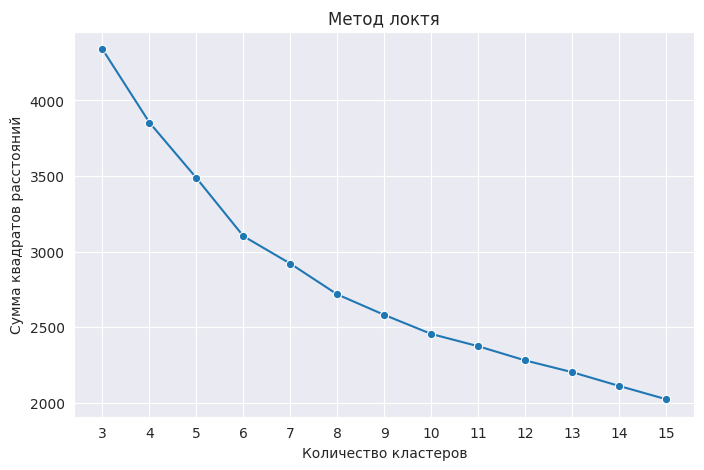

In [84]:
ClusteringEstimator.choose_optimal_n_clusters(
    X=scaled_X, 
    n_clusters_range=[3, 15], 
    method='elbow',
    algorithm='k-means'
)

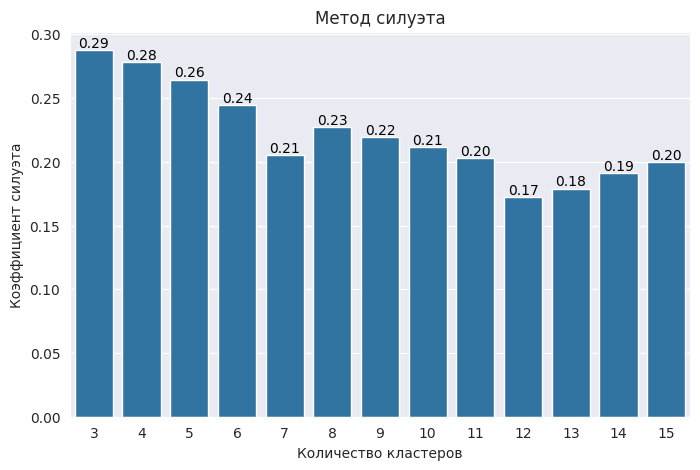

In [85]:
ClusteringEstimator.choose_optimal_n_clusters(
    X=scaled_X, 
    n_clusters_range=[3, 15], 
    method='silhouette',
    algorithm='k-means'
)

In [86]:
kmeans = ClusteringEstimator(algorithm='k-means', n_clusters=8)
kmeans.fit(scaled_X)
kmeans.inertia, kmeans.silhouette

(2800.857510099236, 0.18462523869353464)

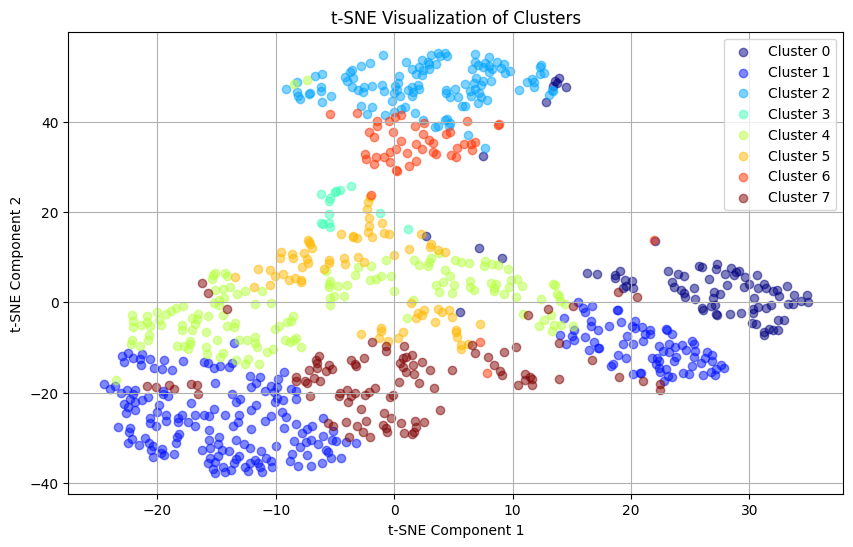

In [65]:
kmeans.plot_clusters_with_tsne()

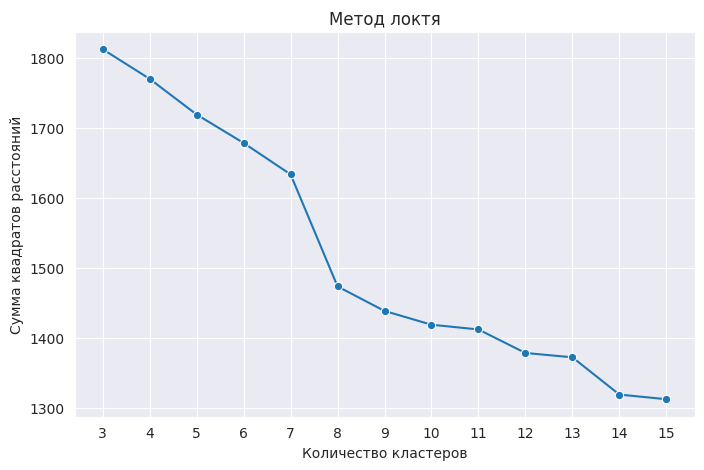

In [74]:
ClusteringEstimator.choose_optimal_n_clusters(
    X=scaled_X, 
    n_clusters_range=[3, 15], 
    method='elbow',
    algorithm='k-medoids'
)

In [87]:
kmedoids = ClusteringEstimator(algorithm='k-medoids', n_clusters=9)
kmedoids.fit(scaled_X)
kmedoids.inertia, kmedoids.silhouette

(1438.44758751034, nan)

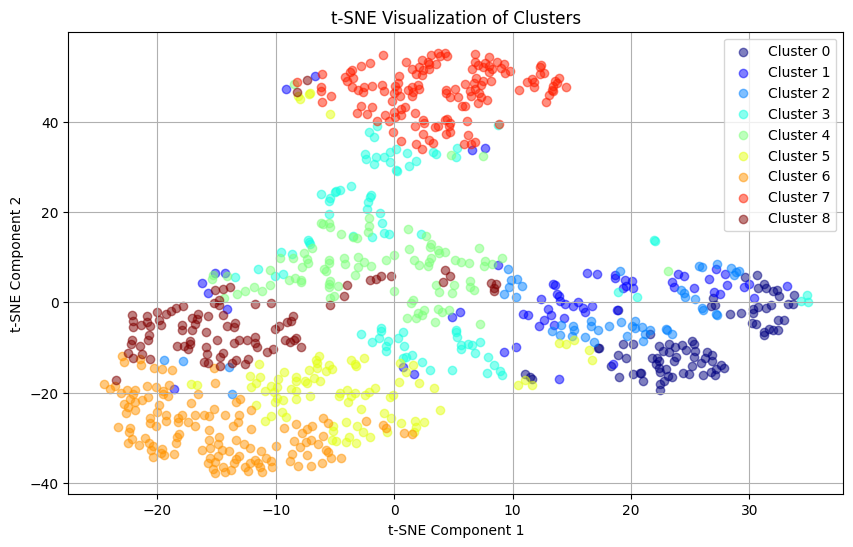

In [76]:
kmedoids.plot_clusters_with_tsne()

# 2. Эксперименты с шумом в данных

In [88]:
noise_fractions = [0.01, 0.03, 0.05, 0.1]  # 1%, 3%, 5%, 10%
n_clusters_range = range(3, 10)  # от 3 до 9
results = []


for noise_fraction in noise_fractions:
    for n_clusters in n_clusters_range:
        # K-Means
        kmeans_estimator = ClusteringEstimator(n_clusters=n_clusters, algorithm='k-means')
        kmeans_estimator.fit(pd.DataFrame(scaled_X), noise_fraction=noise_fraction)
        results.append({
            'method': 'kmeans',
            'n_clusters': n_clusters,
            'noise_fraction': noise_fraction,
            'inertia': kmeans_estimator.inertia
        })

        # K-Medoids
        kmedoids_estimator = ClusteringEstimator(n_clusters=n_clusters, algorithm='k-medoids')
        kmedoids_estimator.fit(pd.DataFrame(scaled_X), noise_fraction=noise_fraction)
        results.append({
            'method': 'kmedoids',
            'n_clusters': n_clusters,
            'noise_fraction': noise_fraction,
            'inertia': kmedoids_estimator.inertia
        })

# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results)

In [89]:
results_df.head()

,method,n_clusters,noise_fraction,inertia
0,kmeans,3,0.01,4503.822011
1,kmedoids,3,0.01,1815.542020
2,kmeans,4,0.01,3781.181818
3,kmedoids,4,0.01,1771.886402
4,kmeans,5,0.01,3485.987644


In [96]:
def plot_algorithm_results(results_df, algorithm, title: str = None):
    if title is None:
        title = algorithm
    y_data = results_df[results_df['method'] == algorithm]
    noise_fractions = y_data['noise_fraction'].unique()

    fig = go.Figure()
    for noise_fraction in noise_fractions:
        data = y_data[y_data['noise_fraction'] == noise_fraction].sort_values('n_clusters')
        label = f'Noise Fraction: {noise_fraction}'
        
        fig.add_trace(go.Scatter(
            x=data['n_clusters'], 
            y=data['inertia'], 
            mode='lines+markers+text', name=f'Noise fraction: {noise_fraction * 100} %', 
            text=data['inertia'].round()
        ))

    fig.update_layout(title=title, xaxis_title='N clusters', yaxis_title='Inertia', legend_title='Noise', template='plotly_white')

    return fig

In [101]:
def compare_algorithms_with_noise_fraction(results_df, noise_fraction: float, title: str = None):
    if title is None:
        title = f'Noise fraction: {noise_fraction * 100} %'

    y_data = results_df[results_df['noise_fraction'] == noise_fraction]
    algorithms = y_data['method'].unique()

    fig = go.Figure()
    for algorithm in algorithms:
        data = y_data[y_data['method'] == algorithm].sort_values('n_clusters')
        label = f'Algorithm: {algorithm}'
        
        fig.add_trace(go.Scatter(
            x=data['n_clusters'], 
            y=data['inertia'], 
            mode='lines+markers+text', name=label, 
            text=data['inertia'].round()
        ))

    return fig
        
    

In [97]:
plot_algorithm_results(results_df, 'kmeans', 'K-Means')

In [98]:
plot_algorithm_results(results_df, 'kmedoids', 'K-Medoids')

In [103]:
compare_algorithms_with_noise_fraction(results_df, noise_fraction=0.01)